Raster CRS: EPSG:32619


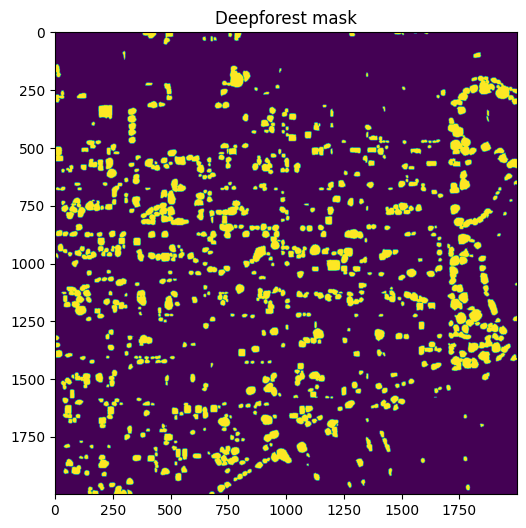

In [1]:
import rasterio as rio
from rasterio.crs import CRS
import matplotlib.pyplot as plt

# Specify the path to your raster file
raster_path = "/Users/michiel/Documents/code/SCL/images/Lukas/verification_bos.tif"

# Load the raster data
with rio.open(raster_path) as src:
    # Read the first band (change index if needed)
    raster_bounds = src.bounds
    band1 = src.read(1)
    raster_transform = src.transform
    # Get metadata (optional)
    print(f"Raster CRS: {src.crs}")

# Plotting the raster data
plt.figure(figsize=(10, 6))
plt.imshow(band1) 
plt.title('Deepforest mask')
plt.show()


In [2]:
import pandas as pd 
import geopandas as gpd
gdf2 = gpd.read_file('/Users/michiel/Documents/code/SCL/images/Lukas/Treekeeper_Street_Trees.shp')

In [13]:

gdf2['geometry'] = gdf2['geometry'].to_crs(32619)
gdf2.crs

<Projected CRS: EPSG:32619>
Name: WGS 84 / UTM zone 19N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, northern hemisphere between equator and 84°N, onshore and offshore. Aruba. Bahamas. Brazil. Canada - New Brunswick (NB); Labrador; Nunavut; Nova Scotia (NS); Quebec. Colombia. Dominican Republic. Greenland. Netherlands Antilles. Puerto Rico. Turks and Caicos Islands. United States. Venezuela.
- bounds: (-72.0, 0.0, -66.0, 84.0)
Coordinate Operation:
- name: UTM zone 19N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

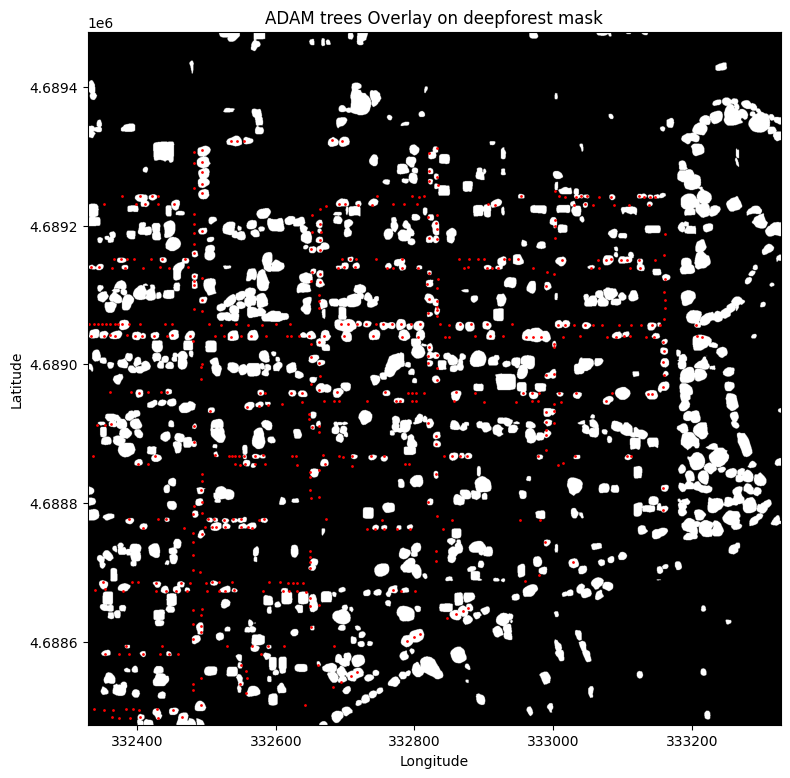

In [14]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box


# create bbox of the tile outline 
bbox = box(raster_bounds.left, raster_bounds.bottom, 
            raster_bounds.right, raster_bounds.top)

# clip trees to bbox of tile 
gdf_clipped = gdf2[gdf2.intersects(bbox)]


# Create a plot to visualize results
fig, ax = plt.subplots(figsize=(15, 9))

# overlay tree mask from deepforest with trees for visual inspection 
rio.plot.show(band1, ax=ax, cmap='gray', extent=rio.plot.plotting_extent(src))
gdf_clipped.plot(ax=ax, color='red', markersize=1)

# Set titles and labels
plt.title('ADAM trees Overlay on deepforest mask')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()




In [22]:
def get_raster_value(point):
    x, y = point.x, point.y
    row, col = rio.transform.rowcol(raster_transform, x, y)
    return band1[row, col]

# Add a new column with extracted raster values
gdf_clipped['raster_value'] = gdf_clipped.geometry.apply(get_raster_value)


gdf_clipped['date_plant'].min()

'--'

In [23]:
print(gdf_clipped.shape[0])
print('percentage of trees detected:', (gdf_clipped['raster_value']==255).sum()/gdf_clipped.shape[0])

557
percentage of trees detected: 0.5044883303411131


In [17]:
# second method where I dont transform the raster
with rio.open('/Users/michiel/Documents/code/SCL/images/Lukas/verification.tif') as src:
    # Get the values at point locations
    gdf_clipped["rastervalue"] = [x[0] for x in src.sample(
        [(point.x, point.y) for point in gdf_clipped.geometry],
        indexes=1
    )]


In [26]:
#same result
print('percentage of trees detected:', (gdf_clipped['raster_value']==255).sum()/gdf_clipped.shape[0])

percentage of trees detected: 0.5044883303411131


In [46]:
gdf_clipped.head()

,id,spp_com,spp_bot,numberof_s,dbh_range,dbh,date_plant,city,neighborho,address,...,suffix,site,x_longitud,y_latitude,shape_wkt,POINT_X,POINT_Y,geometry,raster_value,rastervalue
1065,2070,Honeylocust,Gleditsia triacanthos,1,12-18in,13.0,--,Boston,South Boston,717,...,A,1,-71.0311,42.3340,POINT (-71.031074999999987 42.333973000000071),-71.031075,42.333973,POINT (332670.299 4688855.73),255,0
1067,2072,Honeylocust,Gleditsia triacanthos,1,12-18in,17.0,--,Boston,South Boston,798,...,B,1,-71.0278,42.3367,POINT (-71.02777999999995 42.336697000000072),-71.027780,42.336697,POINT (332948.98 4689151.73),255,0
1071,2076,"Ash, Green",Fraxinus pennsylvanica,1,12-18in,16.0,--,Boston,South Boston,97,...,P,1,-71.0272,42.3347,POINT (-71.027229999999975 42.334713000000079),-71.027230,42.334713,POINT (332989.039 4688930.342),255,0
1075,2080,"Pear, Callery",Pyrus calleryana,1,6-12in,10.0,--,Boston,South Boston,717,...,A,2,-71.0312,42.3339,POINT (-71.031165999999985 42.333897000000036),-71.031166,42.333897,POINT (332662.6 4688847.47),0,0
1132,2119,"Maple, Red",Acer rubrum,1,12-18in,16.0,--,Boston,South Boston,689,...,A,1,-71.0326,42.3323,POINT (-71.032609999999977 42.332310000000064),-71.032610,42.332310,POINT (332539.419 4688674.089),255,0


In [42]:
# Create a new subset DataFrame where raster_value is 255
subset_df = gdf_clipped[gdf_clipped['raster_value'] == 0]

subset_df.columns



Index(['id', 'spp_com', 'spp_bot', 'numberof_s', 'dbh_range', 'dbh',
       'date_plant', 'city', 'neighborho', 'address', 'street', 'suffix',
       'site', 'x_longitud', 'y_latitude', 'shape_wkt', 'POINT_X', 'POINT_Y',
       'geometry', 'raster_value', 'rastervalue'],
      dtype='object')

In [43]:
frequency = subset_df['date_plant'].value_counts().sort_index()

frequency

date_plant
--             215
Fall 2021       10
Fall 2022        6
Fall 2023        5
Fall 2024        8
Spring 2021      6
Spring 2022      8
Spring 2023     14
Spring 2024      4
Name: count, dtype: int64